Encoded labels: [0 1 2]
Class distribution: {0: np.int64(6259), 1: np.int64(1227)}

Model Summary:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 200, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        42,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,042,305 (3.98 MB)

 Trainable params: 1,042,305 (3.98 MB)

 Non-trainable params: 0 (0.00 B)


Training model...
Epoch 1/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 29s 142ms/step - accuracy: 0.4097 - loss: 1.1736 - val_accuracy: 0.8438 - val_loss: 0.6480
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 27s 142ms/step - accuracy: 0.5733 - loss: 1.1594 - val_accuracy: 0.1562 - val_loss: 0.7404
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 40s 135ms/step - accuracy: 0.3111 - loss: 1.1927 - val_accuracy: 0.8438 - val_loss: 0.6643
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 24s 129ms/step - accuracy: 0.4797 - loss: 1.1589 - val_accuracy: 0.8438 - val_loss: 0.6675
Epoch 5/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 42s 133ms/step - accuracy: 0.4573 - loss: 1.1635 - val_accuracy: 0.8438 - val_loss: 0.6871
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step

Evaluation Metrics:
Accuracy: 0.8438
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000


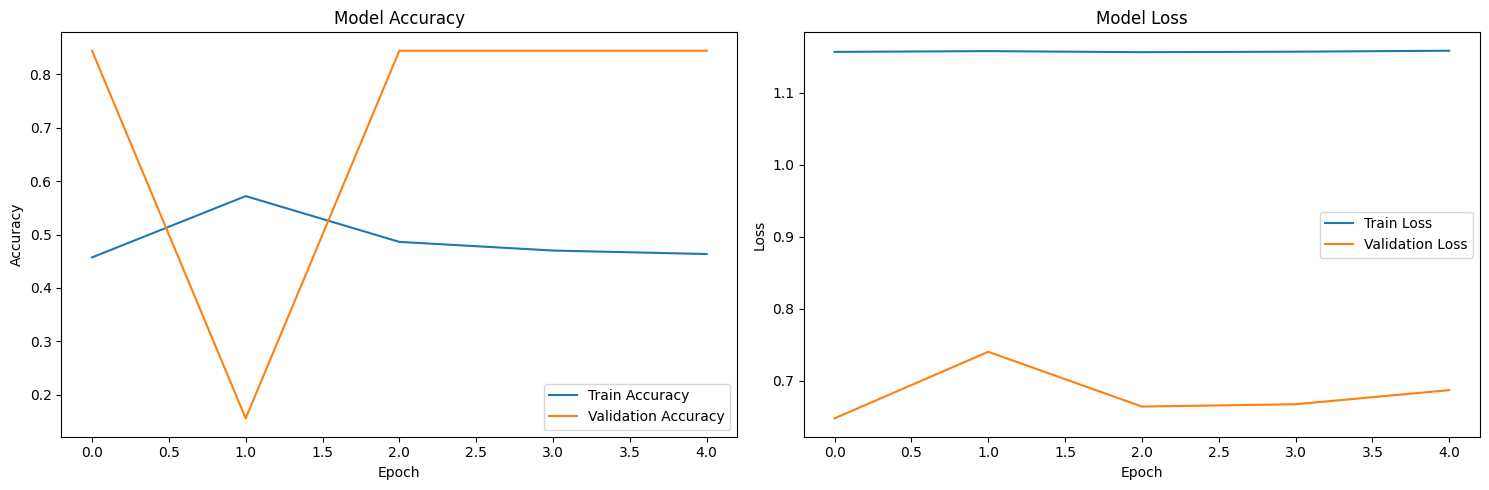

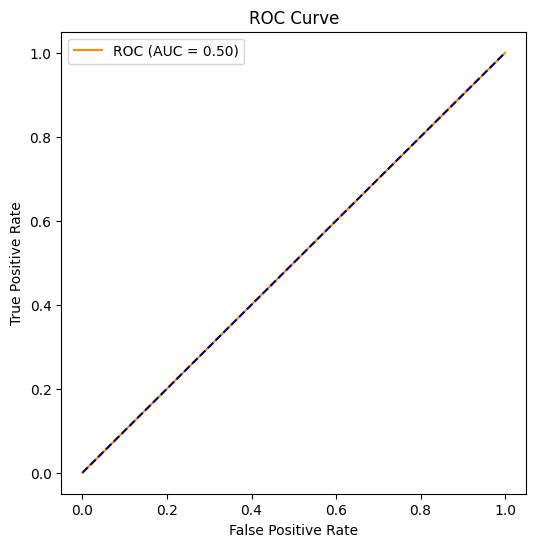

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Load the dataset
try:
    df = pd.read_excel('/content/Depression_Text.xlsx')
    text = df['text'].astype(str).values
    labels = df['label'].values

    # Encode labels to 0 and 1
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(labels)
    print("Encoded labels:", np.unique(labels))
    print("Class distribution:", {0: np.sum(labels == 0), 1: np.sum(labels == 1)})

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(text, labels, test_size=0.2, random_state=42)

    # Tokenization
    max_words = 10000
    tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
    tokenizer.fit_on_texts(X_train)
    X_train_sequences = tokenizer.texts_to_sequences(X_train)
    X_test_sequences = tokenizer.texts_to_sequences(X_test)

    # Padding
    max_length = 200
    X_train_padded = pad_sequences(X_train_sequences, maxlen=max_length, padding='post', truncating='post')
    X_test_padded = pad_sequences(X_test_sequences, maxlen=max_length, padding='post', truncating='post')

    # Model architecture
    embedding_dim = 100
    lstm_units = 64
    model = Sequential([
        Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_length),
        LSTM(lstm_units, return_sequences=False, kernel_initializer='glorot_uniform'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    # Compile the model with gradient clipping
    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )

    # Print model summary after building it with a sample batch
    print("\nModel Summary:")
    model.build(input_shape=(None, max_length))  # Explicitly build the model
    model.summary()

    # Train the model with class weights for imbalance
    class_weights = {0: 1., 1: len(y_train[y_train==0])/len(y_train[y_train==1])}

    print("\nTraining model...")
    history = model.fit(
        X_train_padded,
        y_train,
        epochs=5,
        validation_data=(X_test_padded, y_test),
        batch_size=32,
        class_weight=class_weights,
        verbose=1
    )

    # Evaluation
    y_pred_prob = model.predict(X_test_padded)
    y_pred = (y_pred_prob > 0.5).astype(int)

    print("\nEvaluation Metrics:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred, zero_division=0):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred, zero_division=0):.4f}")
    print(f"F1 Score: {f1_score(y_test, y_pred, zero_division=0):.4f}")

    # Plotting
    plt.figure(figsize=(15, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # ROC curve
    plt.figure(figsize=(6, 6))
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='darkorange', label=f'ROC (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

except Exception as e:
    print(f"\nError occurred: {str(e)}")
    print("\nDebugging info:")
    if 'df' in locals():
        print("DataFrame columns:", df.columns.tolist())
        print("DataFrame shape:", df.shape)
        print("First 5 rows:")
        print(df.head())
    else:
        print("Failed to load DataFrame")